In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
METRIC = "systemic_failure"

In [3]:
df = pd.read_csv("german_credit_results.csv")
#df = pd.read_csv("german_credit_conformal_results.csv")
CONFORMAL = False
N_TRAIN = 800
MIN_DATA_SCALE = 5

In [4]:
df = df.drop(columns=["random_seed", "task_type"])
df = df.groupby(["exp_type", "random_distance", "num_models", "data_scale", "method"]).mean().reset_index(drop=False)
df["data_scale"] = (N_TRAIN/df["data_scale"]).astype(int)

/var/folders/6w/yt_9nm1s5ngbsytz47vfxfjh0000gn/T/ipykernel_25697/3421476323.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(["exp_type", "random_distance", "num_models", "data_scale", "method"]).mean().reset_index(drop=False)


In [5]:
def table_by_models(data, metric, exp_type="baseline", method="lockout", data_scale=10):
    df = data
    df = df[df["data_scale"]==int(N_TRAIN/data_scale)]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["num_models", "random_distance", metric]]
    df = df[df["num_models"]>1]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["num_models"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["num_models"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [6]:
def table_by_data(data, metric, exp_type="baseline", method="lockout", num_models=2):
    df = data
    df = df[df["num_models"]==num_models]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["data_scale", "random_distance", metric]]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["data_scale"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["data_scale"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [7]:
def plot(data, metric, xaxis, exp_type="baseline", method="lockout", ylog=False, ylim=None, save=False):
    plt.rcParams["figure.figsize"] = [7,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[df[xaxis]>1]

    if CONFORMAL:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*-', color='#00060e', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.05, xaxis], df.loc[df["random_distance"]==0.05, metric], '*-', color='#001e49', label="Alpha = 0.05")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#002f70', label="Alpha = 0.1")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#003f97', label="Alpha = 0.2")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#004fbf', label="Alpha = 0.3")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#0068f9', label="Alpha = 0.4")
    else:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*-', color='#00060e', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#001e49', label="Random(0.4,0.6)")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#002f70', label="Random(0.3,0.7)")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#003f97', label="Random(0.2,0.8)")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#004fbf', label="Random(0.1,0.9)")
        plt.plot(df.loc[df["random_distance"]==0.5, xaxis], df.loc[df["random_distance"]==0.5, metric], '*-', color='#0068f9', label="All Random")


    if ylim:
        plt.ylim(ylim)
    if ylog:
        plt.yscale('log')   

    plt.xlabel(xaxis)
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    fig.savefig(metric+'.png')
    plt.show()

# Results -- Accuracy

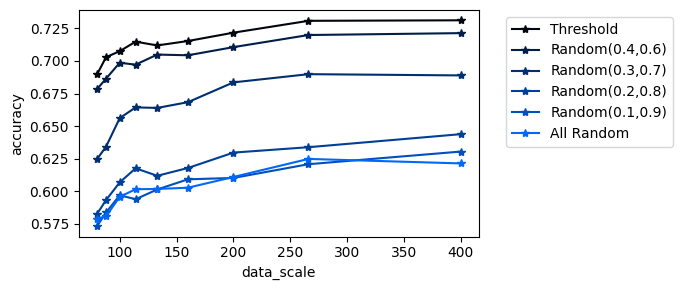

In [8]:
plot(df[df["num_models"]==2], "accuracy", "data_scale")

In [9]:
table_by_models(df, "accuracy")[["random_distance", "2"]].rename(columns={'2':"accuracy"})

,random_distance,accuracy
0,0.0,0.690
1,0.1,0.678
2,0.2,0.625
3,0.3,0.582
4,0.4,0.573
5,0.5,0.579


### Acceptance Rate 

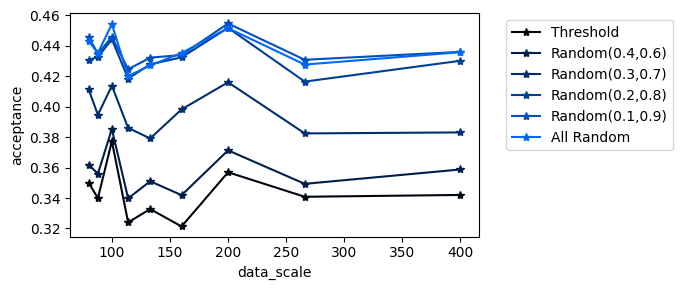

In [10]:
plot(df[df["num_models"]==2], "acceptance", "data_scale")

# Results -- Homogenization As Repeated Inaccurate Decisions

### Baseline: Homogenization Across Same Model Class + Training Data + Prediction Task

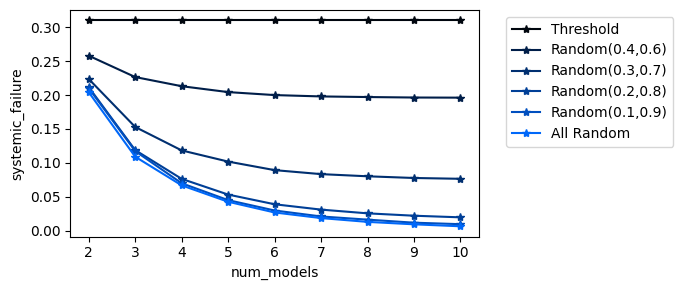

In [11]:
plot(df[df["data_scale"]==(int(N_TRAIN/10))], METRIC, "num_models", "baseline", "inaccurate")

In [12]:
table_by_models(df, METRIC, "baseline", "inaccurate")

,random_distance,2,3,4,5,6,7,8,9,10
0,0.0,0.310,0.310,0.310,0.310,0.310,0.310,0.310,0.310,0.310
1,0.1,0.258,0.227,0.213,0.204,0.200,0.198,0.197,0.196,0.196
2,0.2,0.224,0.153,0.118,0.102,0.089,0.083,0.080,0.078,0.076
3,0.3,0.212,0.119,0.076,0.053,0.039,0.031,0.025,0.022,0.020
4,0.4,0.210,0.117,0.070,0.045,0.030,0.021,0.016,0.012,0.009
5,0.5,0.204,0.109,0.067,0.042,0.027,0.018,0.013,0.009,0.006


### Different Training Data (Same Model Class + Prediction Task)

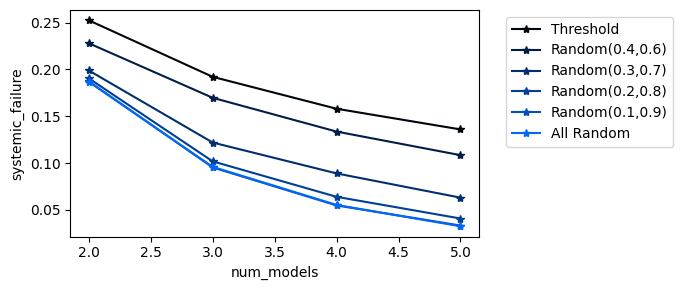

In [13]:
plot(df[df["data_scale"]==(int(N_TRAIN/MIN_DATA_SCALE))], METRIC, "num_models", "data_partitions", "inaccurate")

### Different Model Classes (Same Training Data + Prediction Task)

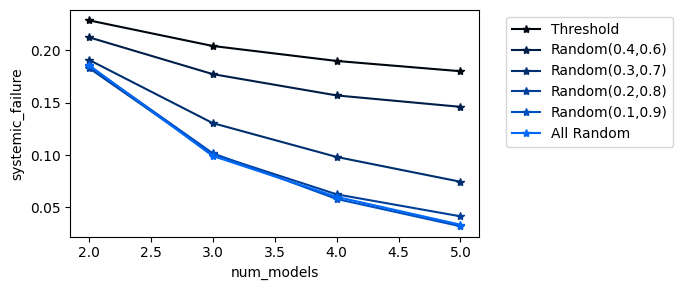

In [14]:
plot(df[df["data_scale"]==(int(N_TRAIN/MIN_DATA_SCALE))], METRIC, "num_models", "models", "inaccurate")

### Different Prediction Tasks (Same Model Class + Training Data)

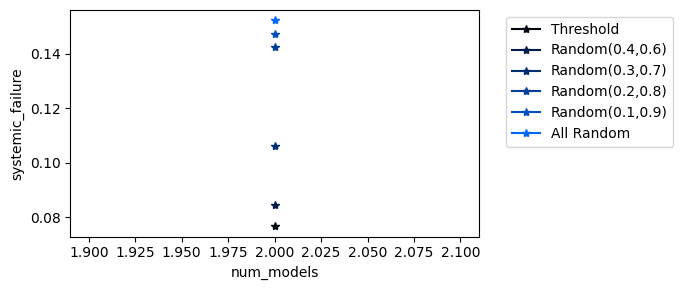

In [15]:
plot(df[df["data_scale"]==(int(N_TRAIN/MIN_DATA_SCALE))], METRIC, "num_models", "tasks", "inaccurate")

# Results -- Homogenization As Repeated Negative Decisions

### Baseline: Homogenization Across Same Model Class + Training Data + Prediction Task

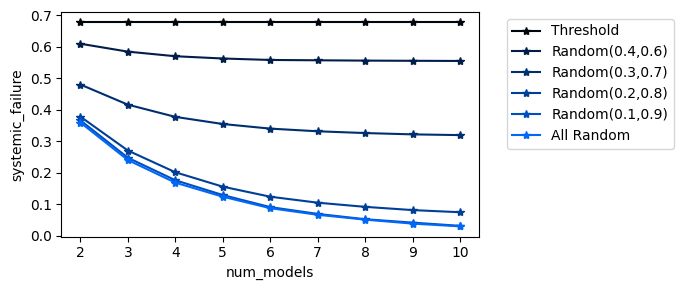

In [16]:
plot(df[df["data_scale"]==(int(N_TRAIN/MIN_DATA_SCALE))], METRIC, "num_models", "baseline", "lockout")

In [17]:
table_by_models(df, METRIC, "baseline", "lockout")

,random_distance,2,3,4,5,6,7,8,9,10
0,0.0,0.650,0.650,0.650,0.650,0.650,0.650,0.650,0.650,0.650
1,0.1,0.574,0.544,0.527,0.519,0.514,0.511,0.510,0.509,0.509
2,0.2,0.437,0.352,0.306,0.281,0.263,0.255,0.248,0.244,0.241
3,0.3,0.363,0.246,0.181,0.138,0.111,0.093,0.081,0.072,0.068
4,0.4,0.337,0.224,0.156,0.106,0.075,0.054,0.041,0.032,0.025
5,0.5,0.340,0.222,0.150,0.107,0.077,0.055,0.038,0.029,0.021


### Different Training Data (Same Model Class + Prediction Task)

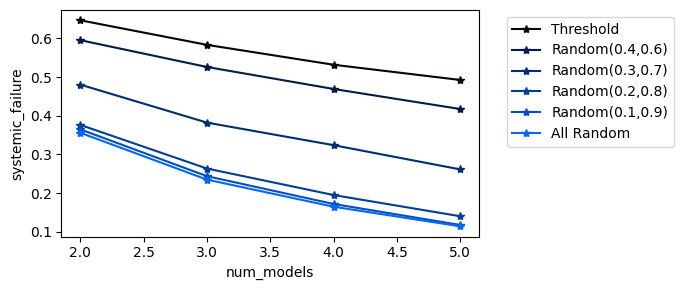

In [18]:
plot(df[df["data_scale"]==(int(N_TRAIN/MIN_DATA_SCALE))], METRIC, "num_models", "data_partitions", "lockout")

### Different Model Classes (Same Training Data + Prediction Task)

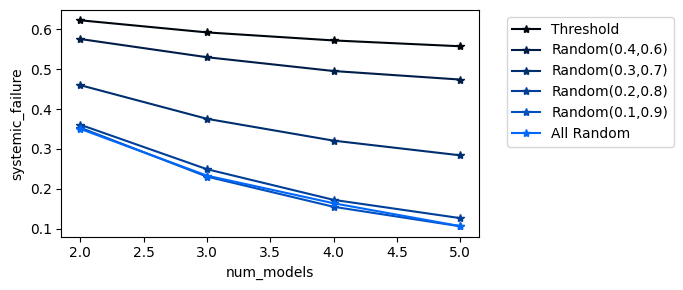

In [19]:
plot(df[df["data_scale"]==(int(N_TRAIN/MIN_DATA_SCALE))], METRIC, "num_models", "models", "lockout")

### Different Prediction Tasks (Same Model Class + Training Data)

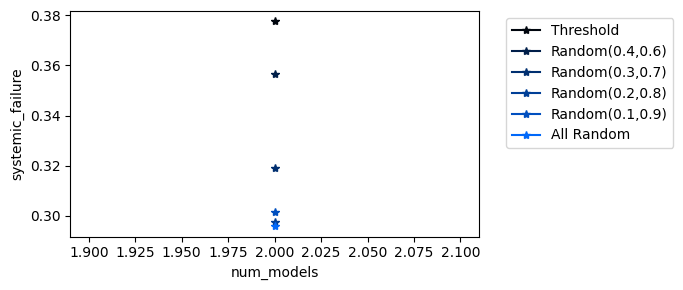

In [20]:
plot(df[df["data_scale"]==(int(N_TRAIN/MIN_DATA_SCALE))], METRIC, "num_models", "tasks", "lockout")

# Results -- By Data Scale

### Homogenization As Repeated Inaccurate Decisions

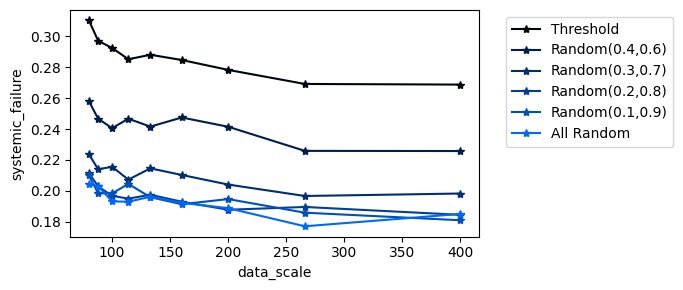

In [21]:
plot(df[df["num_models"]==2], METRIC, "data_scale", "baseline", "inaccurate")

### Homogenization As Repeated Negative Decisions

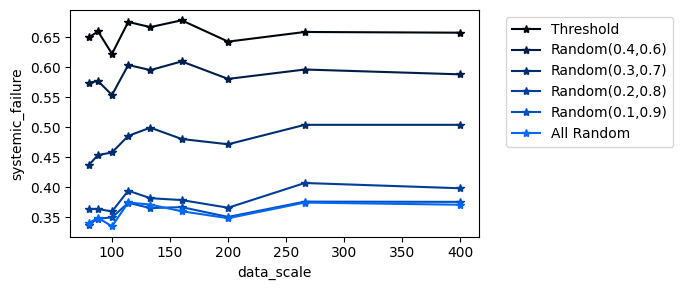

In [22]:
plot(df[df["num_models"]==2], METRIC, "data_scale", "baseline", "lockout")